This is more about *understanding* pandas, "going with the flow", than any particular operation. Alignment is a key part of many parts of pandas, including

- binary operations (`+, -, *, /, **, ==, |, &`)
- merges / joins / concats
- constructors
- reindexing

That said, it's not really something you'll be doing explicitly. It happens in the background, as part of all those tasks.
It's all about using *labels* (`DataFrame.index` and `DataFrame.columns`) to do the tricky work of making sure the operation goes through correctly.

If you thing you have a handle on this, jump down to the exercise at the end of the notebook.

In [15]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import side_by_side
from IPython import display

pd.options.display.max_rows = 10
sns.set(style='white', context='talk')

Let's start out doing things the "wrong" way. We've got data on GDP (total output each quarter) and CPI (a measure of inflation). Each CSV has a column of dates, and a column for the measurement.

In [30]:
cpi = pd.read_csv("data/cpi.csv", parse_dates=['DATE'])
gdp = pd.read_csv("data/gdp.csv", parse_dates=['DATE'])


In [4]:
cpi.head()

,DATE,CPIAUCSL
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [31]:
gdp.head()

,DATE,GDP
0,1947-01-01,243.1
1,1947-04-01,246.3
2,1947-07-01,250.1
3,1947-10-01,260.3
4,1948-01-01,266.2


Typically, we would use `DATE` as the index (`index_col='DATE'` in `read_csv`). But to appreciate the value of labels, we'll take them away for now.

Real GDP is [defined to be wikipedia](https://en.wikipedia.org/wiki/Real_gross_domestic_product) nominal GDP (which is what our `gdp` DataFrame contains) divided by a measure of the *price index*. Typically you'd use the GDP deflator, but we'll use CPI so that I can make a point later.

To calculate real GDP, divide `gdp` by `cpi`. Without meaningful labels, we have to do the alignemnt. We'll find the dates in common between the two series, manually filter to those, and then do the division

In [32]:
# the NumPy Way, find `common` index dates.
common = pd.Index(cpi.DATE).intersection(gdp.DATE)
rgdp = (gdp.loc[gdp.DATE.isin(common), 'GDP'].values /
        cpi.loc[cpi.DATE.isin(common), 'CPIAUCSL'])
rgdp.head()

0     11.317505
3     11.195455
6     11.250562
9     11.361851
12    11.241554
Name: CPIAUCSL, dtype: float64

In [33]:
# The R / database way
m = pd.merge(gdp, cpi, on="DATE")
rgdp = m['GDP'] / m['CPIAUCSL']
rgdp.head()

0    11.317505
1    11.195455
2    11.250562
3    11.361851
4    11.241554
dtype: float64

The better way: Set the `DATE` column to the index, squeeze down to a series, and use the `/` operator.

In [12]:
# %load solutions/alignment_02.py
gdp = gdp.set_index("DATE").squeeze()
cpi = cpi.set_index("DATE").squeeze().rename("cpi")
side_by_side(gdp.head(), cpi.head())


Now when you do the division, pandas will handle the alignemnt.

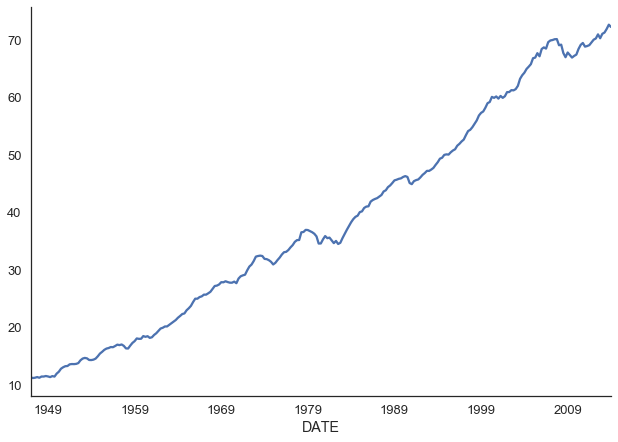

In [16]:
(gdp / cpi).dropna().plot()
sns.despine();

Why the `.dropna`? Let's dig into the auto-alignment a bit.

In [17]:
l, r = gdp.align(cpi)
side_by_side(l.head(), r.head())

`.align` will take the *union* (in the set-theory sense) of the two indexes.

In [20]:
# Take the set unio
idx = gdp.index | cpi.index
idx

DatetimeIndex(['1947-01-01', '1947-02-01', '1947-03-01', '1947-04-01',
               '1947-05-01', '1947-06-01', '1947-07-01', '1947-08-01',
               '1947-09-01', '1947-10-01',
               ...
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01'],
              dtype='datetime64[ns]', name='DATE', length=821, freq=None)

Then the two Series / DataFrames are *reindexed* by the common index.
This is what introduces the `NaN`s

In [21]:
# Reindex both to align, then divide
gdp.reindex(idx) / cpi.reindex(idx)

DATE
1947-01-01    11.317505
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    11.195455
1947-05-01          NaN
                ...    
2015-01-01          NaN
2015-02-01          NaN
2015-03-01          NaN
2015-04-01          NaN
2015-05-01          NaN
dtype: float64

In [22]:
(gdp / cpi).dropna()

DATE
1947-01-01    11.317505
1947-04-01    11.195455
1947-07-01    11.250562
1947-10-01    11.361851
1948-01-01    11.241554
                ...    
2013-01-01    71.124715
2013-04-01    71.343420
2013-07-01    71.962930
2013-10-01    72.711603
2014-01-01    72.313495
dtype: float64

We also see alignment in action with `pd.concat`:

In [24]:
# concat gdp and CPI
pd.concat([gdp, cpi], axis=1)

,GDP,cpi
DATE,,
1947-01-01,243.1,21.480
1947-02-01,NaN,21.620
1947-03-01,NaN,22.000
1947-04-01,246.3,22.000
1947-05-01,NaN,21.950
...,...,...
2015-01-01,NaN,234.954
2015-02-01,NaN,235.415
2015-03-01,NaN,235.859


And `pd.merge`

In [26]:
# Merge DataFrames with left_index & right_index
pd.merge(gdp.to_frame(), cpi.to_frame(), left_index=True, right_index=True,
         how='outer')

,GDP,cpi
DATE,,
1947-01-01,243.1,21.480
1947-02-01,NaN,21.620
1947-03-01,NaN,22.000
1947-04-01,246.3,22.000
1947-05-01,NaN,21.950
...,...,...
2015-01-01,NaN,234.954
2015-02-01,NaN,235.415
2015-03-01,NaN,235.859


## Exercise: JOLTS

During the housing bubble and financial crisis, [CalculatedRisk](http://www.calculatedriskblog.com) was one of the best places for information on the internet. Let's reproduce one of his charts:

In [40]:
display.Image(url='http://1.bp.blogspot.com/-Q60opady2iQ/VNoeGepLMWI/AAAAAAAAiQc/PCA1LfFJFCg/s1600/JOLTSDec2014.PNG')

This shows the components of turnover in the labor market. People leave jobs for two reasons:

1. Quits (light blue) or
2. Layoffs, discharges, or other (red).

Companies post job openings (yellow) and fill some number of those (Blue).
The difference between the openings and hires represents the change in the stock of open positions, and measures the slackness of the labor market.
The difference between the Hires and the sum of Quites and Layoffs / Discharges represents the change in the employed labor force (though the unemployment rate is calculated differently).

To get you started, the FRED series codes are

- JTSJOL: Openings
- JTSQUL: Quits
- JTSHIL: Hires
- JTSLDL: Layoffs

Use the `pandas_datareader.data.DataReader` class, which accepts a list of symbols, and a data_source (`'fred'`).
As a hint, you can use pandas' `.plot.area()` method for the Quits and Layoffs series. That handles all the stacking for you.

In [27]:
from pandas_datareader.data import DataReader

series = ['JTSJOL', 'JTSQUL', 'JTSHIL', 'JTSLDL']
names = ['openings', 'quits', 'hires', 'layoffs']

colors = {'quits': '#52b5ea', 'layoffs': '#d32c2c',
          'hires': '#2531db', 'openings': '#fffb49'}

area_colors = [colors['quits'], colors['layoffs']]
line_colors = [colors['hires'], colors['openings']]

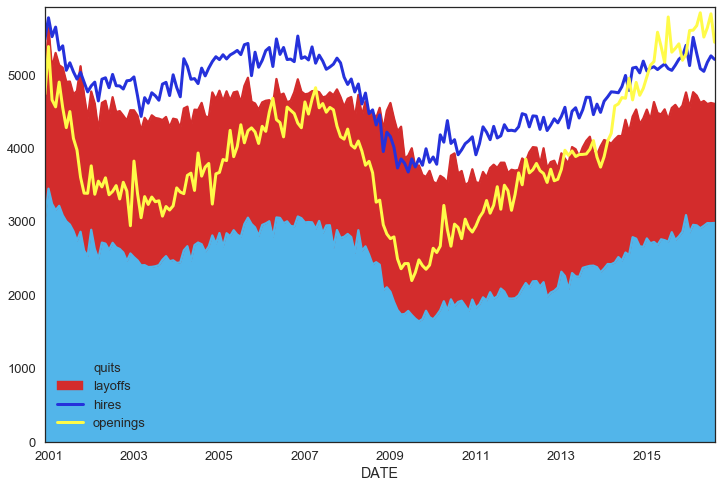

In [29]:
# %load solutions/alignment_03.py
res = DataReader(series, start='2000-01-01', data_source="fred")
res = res.rename(columns=dict(zip(series, names)))

fig, ax = plt.subplots(figsize=(12, 8))
res[['quits', 'layoffs']].plot.area(
    color=area_colors, ax=ax)
res[['hires', 'openings']].plot(
    ax=ax, color=line_colors, linewidth=3);

If you finish that, feel free to poke around [FRED](https://fred.stlouisfed.org) for more interesting series.

## Summary

Use alignment to make things easier on yourself.
Highlights one of the biggest difference between NumPy and pandas.
With NumPy, it was up to *you* to align things *by position*.
If you're deep in the middle of a complicated filtering and grouping
operation, you have to hope you haven't messed anything up. You could
easily end up in a situation where the output looks sensible, but has
been misaligned.

Pandas handles the alignment for you.